# Adversarial Learning

Install the Neural Structured Learning package.

In [ ]:
!pip install --quiet neural-structured-learning

Import libraries. We abbreviate neural_structured_learning to `nsl`.

In [ ]:
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

We collect and explain the hyperparameters (in an HParams object) for model training and evaluation.

Input/Output:

- `input_shape`: The shape of the input tensor. Each image is 28-by-28 pixels with 1 channel.
- `num_classes`: There are a total of 10 classes, corresponding to 10 digits [0-9].

Model architecture:

- `conv_filters`: A list of numbers, each specifying the number of filters in a convolutional layer.
- `kernel_size`: The size of 2D convolution window, shared by all convolutional layers.
- `pool_size`: Factors to downscale the image in each max-pooling layer.
- `num_fc_units`: The number of units (i.e., width) of each fully-connected layer.

Training and evaluation:

- `batch_size`: Batch size used for training and evaluation.
- `epochs`: The number of training epochs.

Adversarial learning:

- `adv_multiplier`: The weight of adversarial loss in the training objective, relative to the labeled loss.
- `adv_step_size`: The magnitude of adversarial perturbation.
- `adv_grad_norm`: The norm to measure the magnitude of adversarial perturbation.

In [ ]:
class HParams(object):
  def __init__(self):
    self.input_shape = [28, 28, 1]
    self.num_classes = 10
    self.conv_filters = [32, 64, 64]
    self.kernel_size = (3, 3)
    self.pool_size = (2, 2)
    self.num_fc_units = [64]
    self.batch_size = 32
    self.epochs = 5
    self.adv_multiplier = 0.2
    self.adv_step_size = 0.2
    self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

In [ ]:
datasets = tfds.load('mnist')

train_dataset = datasets['train']
test_dataset = datasets['test']

IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

To make the model numerically stable, we normalize the pixel values to [0, 1] by mapping the dataset over the normalize function. After shuffling training set and batching, we convert the examples to feature tuples (image, label) for training the base model. We also provide a function to convert from tuples to dictionaries for later use.

In [ ]:
def normalize(features):
  features[IMAGE_INPUT_NAME] = tf.cast(
      features[IMAGE_INPUT_NAME], dtype=tf.float32) / 255.0
  return features

def convert_to_tuples(features):
  return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def convert_to_dictionaries(image, label):
  return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

train_dataset = train_dataset.map(normalize).shuffle(10000).batch(HPARAMS.batch_size).map(convert_to_tuples)
test_dataset = test_dataset.map(normalize).batch(HPARAMS.batch_size).map(convert_to_tuples)

Our base model will be a neural network consisting of 3 convolutional layers follwed by 2 fully-connected layers (as defined in HPARAMS). Here we define it using the Keras functional API. Feel free to try other APIs or model architectures (e.g. subclassing). Note that the NSL framework does support all three types of Keras APIs.

In [ ]:
def build_base_model(hparams):
  """Builds a model according to the architecture defined in `hparams`."""
  inputs = tf.keras.Input(
      shape=hparams.input_shape, dtype=tf.float32, name=IMAGE_INPUT_NAME)

  x = inputs
  for i, num_filters in enumerate(hparams.conv_filters):
    x = tf.keras.layers.Conv2D(
        num_filters, hparams.kernel_size, activation='relu')(
            x)
    if i < len(hparams.conv_filters) - 1:
      # max pooling between convolutional layers
      x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
  x = tf.keras.layers.Flatten()(x)
  for num_units in hparams.num_fc_units:
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
  pred = tf.keras.layers.Dense(hparams.num_classes)(x)
  model = tf.keras.Model(inputs=inputs, outputs=pred)
  return model

In [ ]:
base_model = build_base_model(HPARAMS)
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928 

Next we train and evaluate the base model.

In [ ]:
base_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])
base_model.fit(train_dataset, epochs=HPARAMS.epochs)

Epoch 1/5
1875/1875 [==============================] - 51s 26ms/step - loss: 0.1364 - acc: 0.9568
Epoch 2/5
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0473 - acc: 0.9852
Epoch 3/5
1875/1875 [==============================] - 41s 21ms/step - loss: 0.0320 - acc: 0.9896
Epoch 4/5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0247 - acc: 0.9920
Epoch 5/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0195 - acc: 0.9935


In [ ]:
results = base_model.evaluate(test_dataset)
named_results = dict(zip(base_model.metrics_names, results))
print('\naccuracy:', named_results['acc'])

313/313 [==============================] - 3s 8ms/step - loss: 0.0384 - acc: 0.9889

accuracy: 0.9889000058174133


We can see that the base model achieves 99% accuracy on the test set. We will see how robust it is in Robustness Under Adversarial Perturbations below.

The base model is wrapped to create a new tf.Keras.Model, whose training objective includes adversarial regularization.

First, we create a config object with all relevant hyperparameters using the helper function nsl.configs.make_adv_reg_config.

In [ ]:
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm
)

In [ ]:
base_adv_model = build_base_model(HPARAMS)
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config
)

train_set_for_adv_model = train_dataset.map(convert_to_dictionaries)
test_set_for_adv_model = test_dataset.map(convert_to_dictionaries)

In [ ]:
adv_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])
adv_model.fit(train_set_for_adv_model, epochs=HPARAMS.epochs)

Epoch 1/5


1875/1875 [==============================] - 77s 38ms/step - loss: 0.3089 - sparse_categorical_crossentropy: 0.1407 - sparse_categorical_accuracy: 0.9569 - scaled_adversarial_loss: 0.1682
Epoch 2/5
1875/1875 [==============================] - 72s 38ms/step - loss: 0.1278 - sparse_categorical_crossentropy: 0.0434 - sparse_categorical_accuracy: 0.9865 - scaled_adversarial_loss: 0.0844
Epoch 3/5
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0901 - sparse_categorical_crossentropy: 0.0304 - sparse_categorical_accuracy: 0.9907 - scaled_adversarial_loss: 0.0597
Epoch 4/5
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0696 - sparse_categorical_crossentropy: 0.0243 - sparse_categorical_accuracy: 0.9923 - scaled_adversarial_loss: 0.0453
Epoch 5/5
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0568 - sparse_categorical_crossentropy: 0.0194 - sparse_categorical_accuracy: 0.9938 - scaled_adversarial_loss: 0.0374


In [ ]:
results = adv_model.evaluate(test_set_for_adv_model)
named_results = dict(zip(adv_model.metrics_names, results))
print('\naccuracy:', named_results['sparse_categorical_accuracy'])

313/313 [==============================] - 7s 20ms/step - loss: 0.0493 - sparse_categorical_crossentropy: 0.0225 - sparse_categorical_accuracy: 0.9928 - scaled_adversarial_loss: 0.0268

accuracy: 0.9927999973297119


Now we compare the base model and the adversarial-regularized model for robustness under adversarial perturbation.

We will use the AdversarialRegularization.perturb_on_batch function for generating adversarially perturbed examples. And we would like the generation based on the base model. To do so, we wrap the base model with AdversarialRegularization. Note that as long as we don't invoke training (Model.fit), the learned variables in the model won't change and the model is still the same one as in section Base Model.

In [ ]:
reference_model = nsl.keras.AdversarialRegularization(
    base_model, label_keys=[LABEL_INPUT_NAME], adv_config=adv_config)
reference_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

We collect in a dictionary the models to be evaluted, and also create a metric object for each of the models.

Note that we take adv_model.base_model in order to have the same input format (not requiring label information) as the base model. The learned variables in adv_model.base_model are the same as those in adv_model.

In [ ]:
models_to_eval = {
    'base': base_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

Here is the loop to generate perturbed examples and to evaluate models with them. We save the perturbed images, labels, and predictions for visualization in the next section.

In [ ]:
perturbed_images, labels, predictions = [], [], []

for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  # Clipping makes perturbed examples have the same range as regular ones.
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
  perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
  labels.append(y_true.numpy())
  predictions.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y_true, y_pred)
    predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
  print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.471400
adv-regularized model accuracy: 0.950900


We can see that the accuracy of the base model drops dramatically (from 99% to about 50%) when the input is perturbed adversarially. On the other hand, the accuracy of the adversarial-regularized model only degrades a little (from 99% to 95%). This demonstrates the effectiveness of adversarial learning on improving model's robustness.


Let us also take a look at the adversarially-perturbed images. We can see that the perturbed images still show digits recognizable by human, but can successfully fool the base model.

accuracy in batch 0:
base model: 17 / 32
adv-regularized model: 30 / 32


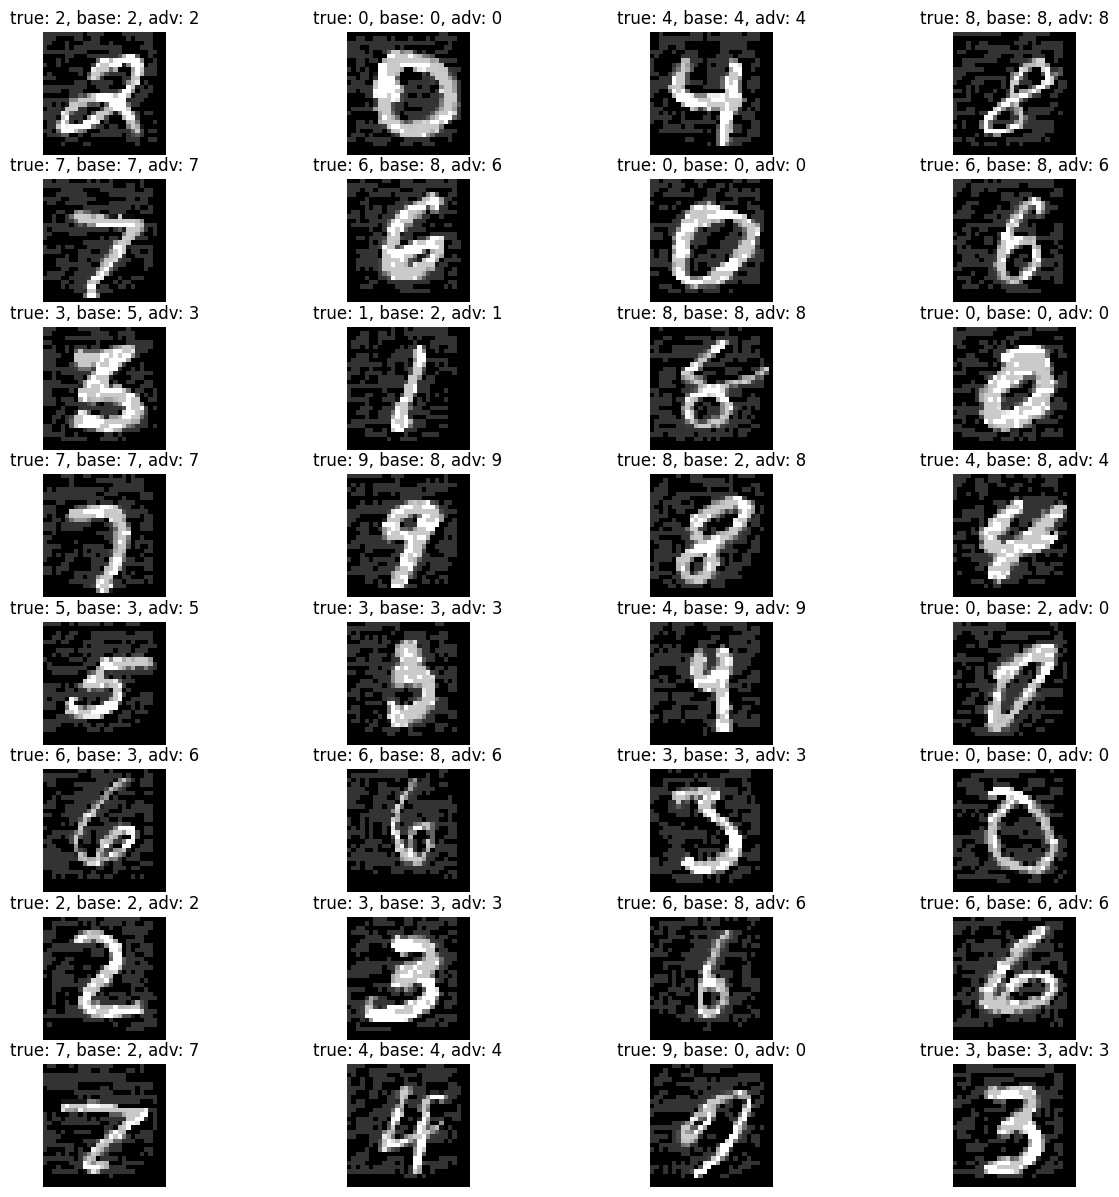

In [ ]:
batch_index = 0

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = HPARAMS.batch_size
n_col = 4
n_row = (batch_size + n_col - 1) // n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
  print('%s model: %d / %d' % (name, np.sum(batch_label == pred), batch_size))

plt.figure(figsize=(15, 15))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
  y_base = batch_pred['base'][i]
  y_adv = batch_pred['adv-regularized'][i]
  plt.subplot(n_row, n_col, i+1)
  plt.title('true: %d, base: %d, adv: %d' % (y, y_base, y_adv))
  plt.imshow(tf.keras.utils.array_to_img(image), cmap='gray')
  plt.axis('off')

plt.show()

We have demonstrated the use of adversarial learning for image classification using the Neural Structured Learning (NSL) framework. We encourage users to experiment with different adversarial settings (in hyper-parameters) and to see how they affect model robustness.